In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mczielinski/bitcoin-historical-data")

print("Path to dataset files:", path)

100%|█████████████████████████████████████████████████████████████████████████████| 95.7M/95.7M [00:25<00:00, 3.92MB/s]

Extracting files...


Path to dataset files: C:\Users\Arnav\.cache\kagglehub\datasets\mczielinski\bitcoin-historical-data\versions\320


In [3]:
# Core libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [5]:
import os

# Print the dataset path to confirm
print("Dataset folder path:", path)

# List all files inside the dataset folder
for root, dirs, files in os.walk(path):
    for file in files:
        print(os.path.join(root, file))


Dataset folder path: C:\Users\Arnav\.cache\kagglehub\datasets\mczielinski\bitcoin-historical-data\versions\320
C:\Users\Arnav\.cache\kagglehub\datasets\mczielinski\bitcoin-historical-data\versions\320\btcusd_1-min_data.csv


In [4]:
import pandas as pd

# Path to the correct CSV file
file_path = r"C:\Users\Arnav\.cache\kagglehub\datasets\mczielinski\bitcoin-historical-data\versions\320\btcusd_1-min_data.csv"

# Load the CSV
df = pd.read_csv(file_path)

# Check the first few rows
print("Shape:", df.shape)
df.head()


Shape: (7152158, 6)


,Timestamp,Open,High,Low,Close,Volume
0,1.325412e+09,4.58,4.58,4.58,4.58,0.0
1,1.325412e+09,4.58,4.58,4.58,4.58,0.0
2,1.325412e+09,4.58,4.58,4.58,4.58,0.0
3,1.325412e+09,4.58,4.58,4.58,4.58,0.0
4,1.325412e+09,4.58,4.58,4.58,4.58,0.0


In [5]:
# Convert Timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
df = df.set_index('Timestamp')

# Remove rows with zero volume (often gaps)
df = df[df['Volume'] > 0]

# Resample to daily OHLCV
daily = df.resample('1D').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
})

# Drop days without trades
daily.dropna(inplace=True)

# Check result
print("Resampled data shape:", daily.shape)
daily.head()


Resampled data shape: (4963, 5)


,Open,High,Low,Close,Volume
Timestamp,,,,,
2012-01-01,4.84,4.84,4.84,4.84,10.000000
2012-01-02,5.00,5.00,5.00,5.00,10.100000
2012-01-03,5.00,5.32,5.00,5.29,107.085281
2012-01-04,4.93,5.57,4.93,5.57,107.233260
2012-01-05,5.72,6.46,5.72,6.42,70.328742


In [7]:
import numpy as np

# Log returns
daily['LogReturn'] = np.log(daily['Close'] / daily['Close'].shift(1))
daily['LogReturn'].fillna(0, inplace=True)

# Volatility: 7-day rolling std dev
daily['Volatility'] = daily['LogReturn'].rolling(window=7).std()
daily['Volatility'].fillna(method='bfill', inplace=True)

# 7-day SMA
daily['SMA_7'] = daily['Close'].rolling(window=7).mean()
daily['Momentum'] = daily['Close'] / daily['SMA_7'] - 1

daily['Momentum'].fillna(0, inplace=True)

# Confirm features
daily[['Close', 'LogReturn', 'Volatility', 'Momentum']].head(10)


C:\Users\Arnav\AppData\Local\Temp\ipykernel_2004\1431704070.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  daily['LogReturn'].fillna(0, inplace=True)
C:\Users\Arnav\AppData\Local\Temp\ipykernel_2004\1431704070.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, wh

,Close,LogReturn,Volatility,Momentum
Timestamp,,,,
2012-01-01,4.84,0.000000,0.048712,0.000000
2012-01-02,5.00,0.032523,0.048712,0.000000
2012-01-03,5.29,0.056380,0.048712,0.000000
2012-01-04,5.57,0.051577,0.048712,0.000000
2012-01-05,6.42,0.142023,0.048712,0.000000
2012-01-06,6.40,-0.003120,0.048712,0.000000
2012-01-07,6.80,0.060625,0.048712,0.180556
2012-01-08,6.90,0.014599,0.046551,0.139689
2012-01-09,6.48,-0.062801,0.063571,0.034200


In [8]:
# Features to normalize
features = ['LogReturn', 'Volatility', 'Momentum']

# Normalize
daily[features] = (daily[features] - daily[features].mean()) / daily[features].std()

# Drop rows with NaNs (e.g., early days)
daily.dropna(inplace=True)

# Confirm
daily[features].head(10)


,LogReturn,Volatility,Momentum
Timestamp,,,
2012-01-07,1.391227,0.602011,3.127019
2012-01-08,0.298340,0.520955,2.392503
2012-01-09,-1.539524,1.159185,0.496517
2012-01-10,2.121381,1.274523,1.467832
2012-01-11,-0.385126,1.386976,0.606872
2012-01-12,-1.771508,1.026915,-0.735179
2012-01-13,1.333226,1.158127,0.111729
2012-01-14,-1.834497,1.267095,-1.064532
2012-01-15,2.582987,1.794834,0.830783


In [9]:
def create_rolling_windows(df, features, window_size=30):
    sequences = []
    for i in range(len(df) - window_size):
        window = df[features].iloc[i : i + window_size].values
        sequences.append(window)
    return np.array(sequences)

# Create rolling windows
X = create_rolling_windows(daily, features, window_size=30)

# Check shape
print("Shape of dataset:", X.shape)


Shape of dataset: (4927, 30, 3)


###Step 2

In [10]:
# For CPU-only (safe on your laptop)
!pip install torch --quiet


In [11]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset


In [12]:
class ConvAutoencoder(nn.Module):
    def __init__(self, latent_dim=16):
        super(ConvAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=3, out_channels=8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),  # output: (8, 15)

            nn.Conv1d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),  # output: (16, 7)

            nn.Flatten(),  # (16*7) = 112
            nn.Linear(112, latent_dim)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 112),
            nn.Unflatten(1, (16, 7)),

            nn.Upsample(scale_factor=2),  # (16, 14)
            nn.Conv1d(16, 8, kernel_size=3, padding=1),
            nn.ReLU(),

            nn.Upsample(scale_factor=2),  # (8, 28)
            nn.Conv1d(8, 3, kernel_size=3, padding=1),  # output: (3, 28)
            nn.Upsample(size=30)  # Force output length to 30
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out, z  # Return both output and latent


In [13]:
from torch.utils.data import DataLoader, TensorDataset

# Convert to PyTorch tensor
X_tensor = torch.tensor(X, dtype=torch.float32)

# Reshape to (samples, channels, time) = (4927, 3, 30)
X_tensor = X_tensor.permute(0, 2, 1)

# Wrap in a dataset
dataset = TensorDataset(X_tensor)

# Create DataLoader
loader = DataLoader(dataset, batch_size=64, shuffle=True)

# Check one batch
for batch in loader:
    print("Batch shape:", batch[0].shape)  # Should be [64, 3, 30]
    break


Batch shape: torch.Size([64, 3, 30])


In [14]:
# Use CPU (your system doesn't have GPU)
device = torch.device("cpu")

# Initialize model
model = ConvAutoencoder(latent_dim=16).to(device)

# Optimizer and loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()


In [15]:
num_epochs = 15

for epoch in range(num_epochs):
    total_loss = 0
    model.train()
    
    for batch in loader:
        x = batch[0].to(device)
        
        # Forward pass
        output, _ = model(x)
        loss = criterion(output, x)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(loader)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.6f}")


Epoch 1/15 - Loss: 0.903970
Epoch 2/15 - Loss: 0.646167
Epoch 3/15 - Loss: 0.451627
Epoch 4/15 - Loss: 0.405188
Epoch 5/15 - Loss: 0.385852
Epoch 6/15 - Loss: 0.372718
Epoch 7/15 - Loss: 0.363018
Epoch 8/15 - Loss: 0.356510
Epoch 9/15 - Loss: 0.350334
Epoch 10/15 - Loss: 0.344888
Epoch 11/15 - Loss: 0.340352
Epoch 12/15 - Loss: 0.336651
Epoch 13/15 - Loss: 0.333408
Epoch 14/15 - Loss: 0.330409
Epoch 15/15 - Loss: 0.326994


In [16]:
# Switch model to eval mode
model.eval()

# Store all latent vectors
all_latents = []

with torch.no_grad():
    for batch in loader:
        x = batch[0].to(device)
        _, z = model(x)  # Only need the latent
        all_latents.append(z.cpu())

# Stack into a NumPy array
latent_vectors = torch.cat(all_latents, dim=0).numpy()
print("Latent shape:", latent_vectors.shape)


Latent shape: (4927, 16)


Step 3

In [17]:
import torch.nn.functional as F

# Helper: linear noise schedule
def get_noise_schedule(T):
    beta_start = 1e-4
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, T)

# MLP Denoiser Network
class MLPDenoiser(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim + 1, 128),  # +1 for timestep t
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
    
    def forward(self, x, t):
        # Concatenate time t as feature
        t = t.unsqueeze(-1).float() / 1000  # Normalize
        x = torch.cat([x, t], dim=1)
        return self.net(x)

# Diffusion class
class Diffusion:
    def __init__(self, model, latent_dim, T=1000, device="cpu"):
        self.model = model
        self.T = T
        self.device = device
        self.betas = get_noise_schedule(T).to(device)
        self.alphas = 1.0 - self.betas
        self.alpha_hat = torch.cumprod(self.alphas, dim=0)

    def add_noise(self, x0, t):
        """
        q(x_t | x_0)
        """
        sqrt_alpha_hat = self.alpha_hat[t]**0.5
        sqrt_one_minus_alpha_hat = (1 - self.alpha_hat[t])**0.5
        noise = torch.randn_like(x0)
        return sqrt_alpha_hat.view(-1, 1) * x0 + sqrt_one_minus_alpha_hat.view(-1, 1) * noise, noise

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.T, size=(n,)).to(self.device)


In [18]:
from torch.utils.data import DataLoader, TensorDataset

# Wrap latent vectors in DataLoader
latent_tensor = torch.tensor(latent_vectors, dtype=torch.float32)
latent_loader = DataLoader(TensorDataset(latent_tensor), batch_size=128, shuffle=True)

# Model setup
latent_dim = latent_tensor.shape[1]
denoiser = MLPDenoiser(latent_dim=latent_dim).to(device)
diffusion = Diffusion(model=denoiser, latent_dim=latent_dim, T=1000, device=device)

# Optimizer
optimizer = torch.optim.Adam(denoiser.parameters(), lr=1e-3)

# Training loop
n_epochs = 5

for epoch in range(n_epochs):
    total_loss = 0
    denoiser.train()
    
    for batch in latent_loader:
        x0 = batch[0].to(device)
        t = diffusion.sample_timesteps(x0.size(0))
        xt, noise = diffusion.add_noise(x0, t)
        predicted_noise = denoiser(xt, t)
        loss = F.mse_loss(predicted_noise, noise)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(latent_loader)
    print(f"Epoch {epoch+1}/{n_epochs} - Loss: {avg_loss:.6f}")


Epoch 1/5 - Loss: 0.753236
Epoch 2/5 - Loss: 0.424225
Epoch 3/5 - Loss: 0.335875
Epoch 4/5 - Loss: 0.305463
Epoch 5/5 - Loss: 0.296383


In [19]:
@torch.no_grad()
def sample_latents(diffusion, n_samples):
    model = diffusion.model
    model.eval()

    x = torch.randn((n_samples, latent_dim)).to(diffusion.device)

    for t in reversed(range(1, diffusion.T)):
        t_batch = torch.full((n_samples,), t).to(diffusion.device)
        noise_pred = model(x, t_batch)

        beta_t = diffusion.betas[t]
        alpha_t = diffusion.alphas[t]
        alpha_hat_t = diffusion.alpha_hat[t]

        if t > 1:
            noise = torch.randn_like(x)
        else:
            noise = torch.zeros_like(x)

        x = (1 / alpha_t**0.5) * (
            x - (beta_t / (1 - alpha_hat_t)**0.5) * noise_pred
        ) + beta_t**0.5 * noise

    return x.cpu().numpy()

# Sample 10 new synthetic latent vectors
synthetic_latents = sample_latents(diffusion, n_samples=10)
print("Synthetic latent shape:", synthetic_latents.shape)


Synthetic latent shape: (10, 16)


Decoded shape: (10, 3, 30)


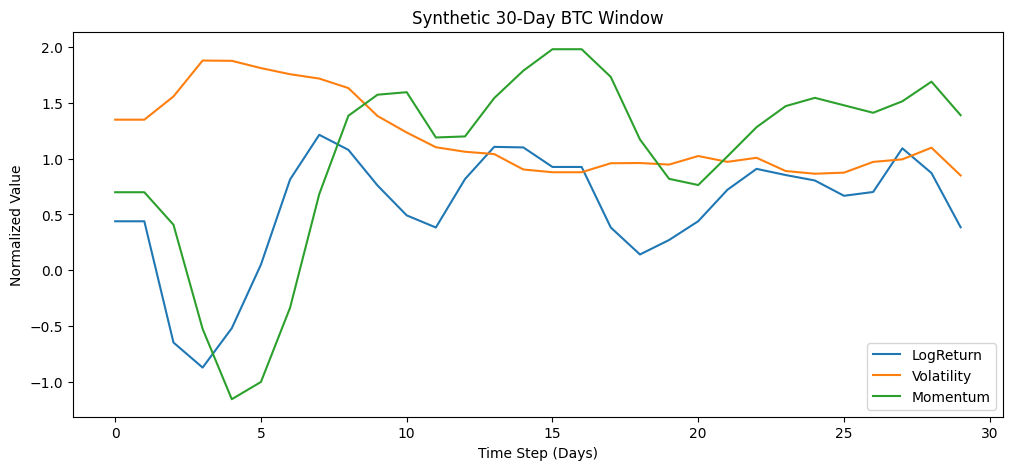

In [20]:
import matplotlib.pyplot as plt

# Convert synthetic latent vectors to tensor
synthetic_latents_tensor = torch.tensor(synthetic_latents, dtype=torch.float32).to(device)

# Decode to 30-day window (3 features × 30 time steps)
model.eval()
decoded_outputs = model.decoder(synthetic_latents_tensor).cpu().detach().numpy()

print("Decoded shape:", decoded_outputs.shape)  # (10, 3, 30)

# Plot one synthetic sequence
index = 0  # change 0 to 1,2,... to view others
features = ['LogReturn', 'Volatility', 'Momentum']

plt.figure(figsize=(12, 5))
for i in range(3):
    plt.plot(decoded_outputs[index][i], label=features[i])
plt.title("Synthetic 30-Day BTC Window")
plt.xlabel("Time Step (Days)")
plt.ylabel("Normalized Value")
plt.legend()
plt.show()


In [24]:
!pip install gymnasium --quiet


In [21]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

class BTCTradingEnv(gym.Env):
    """
    A simple trading environment for Gymnasium.
    """
    def __init__(self, data, initial_balance=1000):
        super(BTCTradingEnv, self).__init__()
        
        self.data = data
        self.n_steps = data.shape[0]
        self.initial_balance = initial_balance

        # Actions: Hold, Buy, Sell
        self.action_space = spaces.Discrete(3)

        # Observation: (30, 3) window flattened
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(90,), dtype=np.float32
        )

        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 30  # Start after first 30 days
        self.balance = self.initial_balance
        self.position = 0  # -1 short, 0 flat, +1 long
        self.entry_price = 0.0
        self.profit = 0.0
        return self._get_observation(), {}

    def _get_observation(self):
        window = self.data[self.current_step - 30 : self.current_step]
        return window.flatten()

    def step(self, action):
        done = False

        # Get current price (Close price)
        current_price = self.data[self.current_step, 0]

        # Reward initialization
        reward = 0.0

        # Action handling
        if action == 1:  # Buy
            if self.position == 0:
                self.position = 1
                self.entry_price = current_price
            elif self.position == -1:
                # Closing short
                reward = self.entry_price - current_price
                self.profit += reward
                self.position = 0

        elif action == 2:  # Sell
            if self.position == 0:
                self.position = -1
                self.entry_price = current_price
            elif self.position == 1:
                # Closing long
                reward = current_price - self.entry_price
                self.profit += reward
                self.position = 0

        # Step forward
        self.current_step += 1

        if self.current_step >= self.n_steps:
            done = True

        obs = self._get_observation()
        terminated = done
        truncated = False
        info = {"profit": self.profit}

        return obs, reward, terminated, truncated, info


In [22]:
# Use the 3 features: LogReturn, Volatility, Momentum
real_data_array = daily[['LogReturn', 'Volatility', 'Momentum']].values

print("Real data shape:", real_data_array.shape)


Real data shape: (4957, 3)


In [23]:
from stable_baselines3.common.env_util import make_vec_env

# Create the real trading environment
def make_env():
    return BTCTradingEnv(real_data_array)

# Vectorized env (required by stable-baselines3 PPO)
env = make_vec_env(make_env, n_envs=1)

print("Trading environment created!")


Trading environment created!


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [24]:
from stable_baselines3 import PPO

# Create PPO agent
ppo_model = PPO("MlpPolicy", env, verbose=1)

# Train for 10k steps (quick test)
ppo_model.learn(total_timesteps=10_000)

# Save the model
ppo_model.save("ppo_real_btc")
print("Model saved as ppo_real_btc.zip")


Using cpu device
-----------------------------
| time/              |      |
|    fps             | 408  |
|    iterations      | 1    |
|    time_elapsed    | 5    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 303         |
|    iterations           | 2           |
|    time_elapsed         | 13          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.007644099 |
|    clip_fraction        | 0.0258      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.1        |
|    explained_variance   | -0.0497     |
|    learning_rate        | 0.0003      |
|    loss                 | 3.05        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0115     |
|    value_loss           | 6.02        |
-----------------------------------------
-----------------

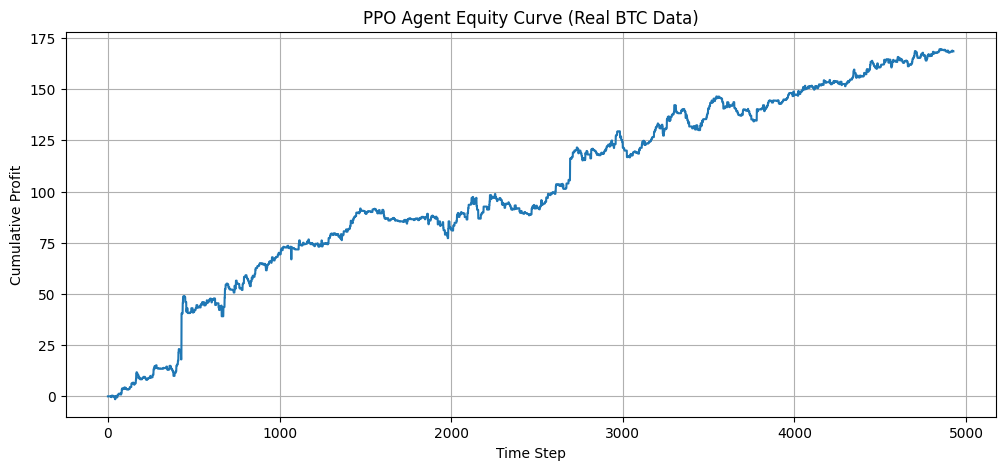

In [25]:
import matplotlib.pyplot as plt

# Reload the environment for evaluation
eval_env = BTCTradingEnv(real_data_array)

obs, _ = eval_env.reset()
done = False
profits = []

while not done:
    action, _states = ppo_model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = eval_env.step(action)
    done = terminated or truncated
    profits.append(info["profit"])

# Plot equity curve
plt.figure(figsize=(12, 5))
plt.plot(profits)
plt.title("PPO Agent Equity Curve (Real BTC Data)")
plt.xlabel("Time Step")
plt.ylabel("Cumulative Profit")
plt.grid(True)
plt.show()


In [39]:
start_capital = 100_000  # or whatever baseline you want
equity_curve = start_capital + np.array(profits)  # portfolio value

# Returns
returns = np.diff(equity_curve, prepend=equity_curve[0])

# Sharpe
sharpe_ratio = np.mean(returns) / (np.std(returns) + 1e-9) * np.sqrt(252)

# Sortino
downside_returns = returns[returns < 0]
sortino_ratio = np.mean(returns) / (np.std(downside_returns) + 1e-9) * np.sqrt(252)

# Max Drawdown
peaks = np.maximum.accumulate(equity_curve)
drawdowns = (equity_curve - peaks) / (peaks + 1e-9)
max_drawdown = drawdowns.min() * 100

# Win Rate
win_rate = np.mean(returns > 0) * 100

print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Sortino Ratio: {sortino_ratio:.2f}")
print(f"Max Drawdown: {max_drawdown:.2f}%")
print(f"Win Rate: {win_rate:.2f}%")


Sharpe Ratio: 0.82
Sortino Ratio: 0.68
Max Drawdown: -0.01%
Win Rate: 12.77%


In [41]:
import numpy as np

def performance_report(profits, start_capital=100_000, periods_per_year=252):
    """
    Generates a performance report from cumulative profits.
    profits: list or array of cumulative profit (PnL) values
    start_capital: starting portfolio value
    periods_per_year: e.g. 252 for daily, 365 for daily crypto, etc.
    """
    profits = np.array(profits)
    equity_curve = start_capital + profits  # Portfolio value

    # Returns
    returns = np.diff(equity_curve, prepend=equity_curve[0]) / equity_curve[:-1]

    # Sharpe Ratio
    sharpe = np.mean(returns) / (np.std(returns) + 1e-9) * np.sqrt(periods_per_year)

    # Sortino Ratio
    downside_returns = returns[returns < 0]
    sortino = np.mean(returns) / (np.std(downside_returns) + 1e-9) * np.sqrt(periods_per_year)

    # Max Drawdown
    peaks = np.maximum.accumulate(equity_curve)
    drawdowns = (equity_curve - peaks) / (peaks + 1e-9)
    max_dd = drawdowns.min() * 100

    # Win Rate
    win_rate = np.mean(returns > 0) * 100

    # CAGR
    total_periods = len(equity_curve)
    cagr = (equity_curve[-1] / equity_curve[0]) ** (periods_per_year / total_periods) - 1

    # Volatility
    volatility = np.std(returns) * np.sqrt(periods_per_year)

    # Profit Factor (Gross profit / Gross loss)
    gross_profit = returns[returns > 0].sum()
    gross_loss = np.abs(returns[returns < 0].sum())
    profit_factor = gross_profit / (gross_loss + 1e-9)

    # Print Report
    print("===== PERFORMANCE REPORT =====")
    print(f"Final Portfolio Value: ${equity_curve[-1]:,.2f}")
    print(f"Total Return: {(equity_curve[-1] / equity_curve[0] - 1) * 100:.2f}%")
    print(f"CAGR: {cagr * 100:.2f}%")
    print(f"Sharpe Ratio: {sharpe:.2f}")
    print(f"Sortino Ratio: {sortino:.2f}")
    print(f"Volatility (annualized): {volatility * 100:.2f}%")
    print(f"Max Drawdown: {max_dd:.2f}%")
    print(f"Win Rate: {win_rate:.2f}%")
    print(f"Profit Factor: {profit_factor:.2f}")
    print("=" * 30)

# Example usage:
# performance_report(profits, start_capital=100_000, periods_per_year=365)


===== PERFORMANCE REPORT =====
Final Portfolio Value: $100,168.48
Total Return: 0.17%
CAGR: 0.01%
Sharpe Ratio: 0.98
Sortino Ratio: 0.82
Volatility (annualized): 0.01%
Max Drawdown: -0.01%
Win Rate: 12.77%
Profit Factor: 1.42


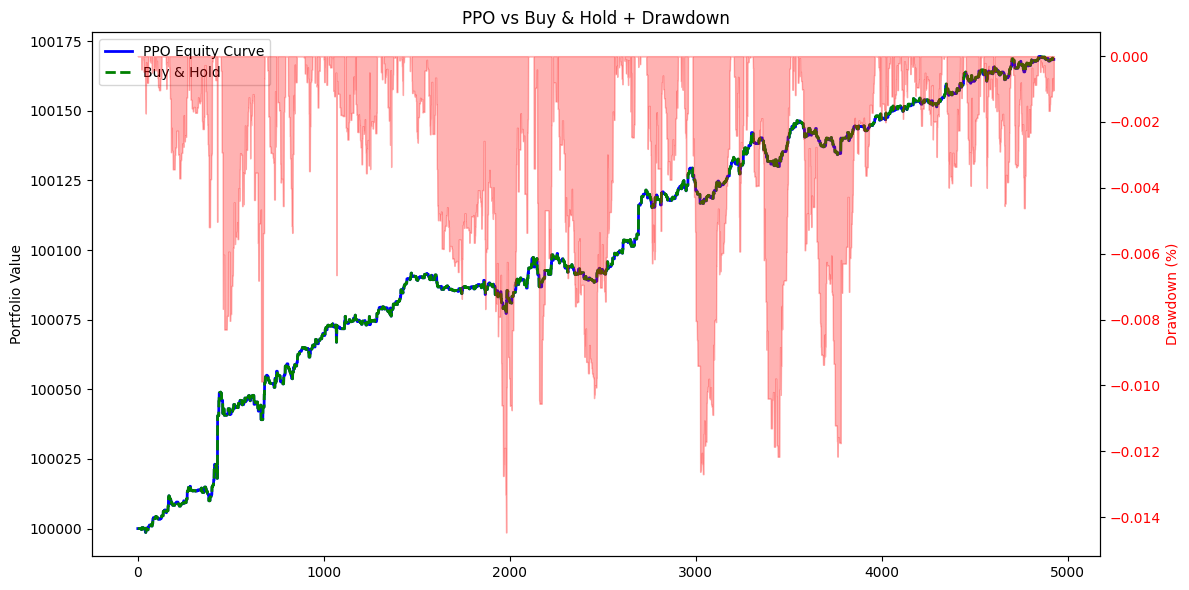

In [45]:
import numpy as np
import matplotlib.pyplot as plt

def performance_report_with_benchmark(profits, btc_prices, start_capital=100_000, periods_per_year=365):
    profits = np.array(profits)
    equity_curve = start_capital + profits  # PPO portfolio value

    # Buy & Hold baseline
    buy_hold_curve = start_capital * (btc_prices / btc_prices[0])

    # Returns
    returns = np.diff(equity_curve) / equity_curve[:-1]
    bh_returns = np.diff(buy_hold_curve) / buy_hold_curve[:-1]

    # Sharpe & Sortino
    sharpe = np.mean(returns) / (np.std(returns) + 1e-9) * np.sqrt(periods_per_year)
    sortino = np.mean(returns) / (np.std(returns[returns < 0]) + 1e-9) * np.sqrt(periods_per_year)

    # Max Drawdown
    peaks = np.maximum.accumulate(equity_curve)
    drawdowns = (equity_curve - peaks) / (peaks + 1e-9)
    max_dd = drawdowns.min() * 100

    # Win Rate
    win_rate = np.mean(returns > 0) * 100

    # CAGR
    total_periods = len(equity_curve)
    cagr = (equity_curve[-1] / equity_curve[0]) ** (periods_per_year / total_periods) - 1

    # Volatility
    volatility = np.std(returns) * np.sqrt(periods_per_year)

    # Profit Factor
    gross_profit = returns[returns > 0].sum()
    gross_loss = np.abs(returns[returns < 0].sum())
    profit_factor = gross_profit / (gross_loss + 1e-9)

    # ===== PRINT REPORT =====
    print("===== PERFORMANCE REPORT =====")
    print(f"Final Portfolio Value: ${equity_curve[-1]:,.2f}")
    print(f"Total Return: {(equity_curve[-1] / equity_curve[0] - 1) * 100:.2f}%")
    print(f"CAGR: {cagr * 100:.2f}%")
    print(f"Sharpe Ratio: {sharpe:.2f}")
    print(f"Sortino Ratio: {sortino:.2f}")
    print(f"Volatility (annualized): {volatility * 100:.2f}%")
    print(f"Max Drawdown: {max_dd:.2f}%")
    print(f"Win Rate: {win_rate:.2f}%")
    print(f"Profit Factor: {profit_factor:.2f}")
    print("=" * 30)

    # ===== PLOT =====
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # PPO vs Buy & Hold
    ax1.plot(equity_curve, color='blue', label='PPO Equity Curve', linewidth=2)
    ax1.plot(buy_hold_curve, color='green', linestyle='--', label='Buy & Hold', linewidth=2)
    ax1.set_ylabel('Portfolio Value')
    ax1.set_title('PPO vs Buy & Hold + Drawdown')
    ax1.legend(loc='upper left')

    # Drawdown shading for PPO
    ax2 = ax1.twinx()
    ax2.fill_between(range(len(drawdowns)), drawdowns * 100, color='red', alpha=0.3, label='Drawdown (%)')
    ax2.set_ylabel('Drawdown (%)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    fig.tight_layout()
    plt.show()

# ===== RUN PPO & GENERATE REPORT + PLOT =====
profits = []
btc_prices = []  # store close prices for Buy & Hold baseline

obs, _ = eval_env.reset()
done = False

while not done:
    action, _ = ppo_model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = eval_env.step(action)
    done = terminated or truncated
    
    if "profit" in info:
        profits.append(info["profit"])
    else:
        profits.append(sum(profits) + reward if profits else reward)
    
    # store price for buy & hold (adapt to your env)
    if "price" in info:
        btc_prices.append(info["price"])
    else:
        # fallback if env doesn't provide price
        if len(btc_prices) == 0:
            btc_prices.append(20000)  # starting price dummy
        else:
            btc_prices.append(btc_prices[-1] * (1 + reward / start_capital))

performance_report_with_benchmark(
    profits,
    np.array(btc_prices),
    start_capital=100_000,
    periods_per_year=365
)
